# Investigating and Correcting Bias in NLP Models

Investigating and correcting bias in algorithms. Method of converting unstructured text into numerical representations (vectors) that also embed semantic understanding into the numerical feature space. This is commonly known as word2vec, and used in many computational Natural Language Processing (NLP) tasks, such as: text prediction, document topic classification, language translation and many more.

## Learning Objectives:

- Investigate word similarity a pre-trained word embedding model.
- Use word embeddings to solve word analogy problems.
- Design counter factual word analogies to detect bias in the word embedding model.
- Modify the word embedding model to reduce its gender bias.
- Critically reflect on the effectiveness and limitations of the de-bais methods used.


In [1]:
import sys
import os
# import tensorflow as tf
from platform import python_version 

#------------- Load in some helpful packages -------------------------

import numpy as np
from w2v_utils import * 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE


#------------- Print versions an paths for potencial debugging -------------------------

print('Python version:', python_version()) # print the version of python the script is using
print('Python path:', sys.executable) # print the path for the python executable the script is using
print('Working Directory:', os.getcwd()) # print the current working directory 
# print ("TensorFlow version: " + tf.__version__) # print the tensorflow version



Python version: 3.11.5
Python path: c:\Users\hgnis\anaconda3\python.exe
Working Directory: d:\ProgrammingSpaceMain\abuses-biases-in-data\Bias NLP lab


# 1. Vectorised Word Embeddings Models

Word vectors are generated using supervised training in the form of an auto-encoder.

The input to the network is a 1-hot vector (a vector which all values are 0 except the value corresponding to the input word). This essentially acts as a mask on the embedding space, so that only the input word outputs nonzero activations from the embedding space through to the output layer. The output layer then predicts expected word based on the input words. The training objective function is a simple measure of the prediction performance. For the workbook we will work on the word embeddings - that are the outputs of the hidden layer from above, for each word - post training.


## 1.1 Load the Word Embedding Vectors. 

Using 50-dimensional GloVe vectors to represent words.

In [2]:
words, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

In [3]:
num_words = len(words)
print(num_words)

word = "father"
print(word_to_vec_map[word])
# investigating more words
print(word_to_vec_map["evil"])
print(word_to_vec_map["reflection"])
print(word_to_vec_map["syndrome"])
print(word_to_vec_map["pulse"])
print(word_to_vec_map["virus"])


400000
[ 0.095496   0.70418   -0.40777   -0.80844    1.256      0.77071
 -1.0695     0.76847   -0.87813   -0.0080954  0.43884    1.0476
 -0.45071   -0.58931    0.83246   -0.038442  -0.73533    0.26389
  0.12617    0.57623   -0.23866    1.0922    -0.3367     0.081537
  0.84798   -2.4795    -0.40351   -0.84087    0.12034    0.29074
  1.9711    -0.50886   -0.45977   -0.13617    0.55613    0.22924
 -0.18947    0.43544    0.65151    0.043537  -0.1162     0.72196
 -0.66163   -0.17272    0.27367   -0.28169   -0.82025   -1.5089
  0.052787  -0.035579 ]
[ 0.76567   -0.007752  -0.28001   -0.22007    1.2617     0.44802
  1.519     -0.49086   -0.53432    0.72989   -0.25435    1.5748
 -0.5606     0.38719    0.036257   0.13234    0.69087    0.42111
 -0.72543    0.61388   -0.53527    0.11526    0.57465   -0.0066877
  0.41334   -1.7219    -1.1447    -0.53068    1.2494    -0.20739
  1.4562    -0.011057  -0.69431   -0.75299   -0.71556    0.31185
 -0.40735   -1.0304    -0.88434   -0.67811   -0.078053  -0.

## 1.2  Visualising  Word Vectors

Investigating the semantic meaning embedded in the word vectors.


In [4]:
def viz_vectors(word_to_vec_map, vec_max, vec_min, word_1, word_2, word_3):
    """
    This funtion accepts three words and returns a figure handle for a plot.
    
    Inputs:
    word_to_vec_map - data dictionary conatin a map form work 'keys' to vectors
    vec_max  - a float containg maximum vector element value in dictionary
    vec_min - a float containg lowest vector element value in dictionary
    word_1 - string containing a word 
    word_2 - string containing a word
    word_3 - string containing a word
    
    Outputs:
    fig - a handle to a plot
    """

    wordvec_1 = word_to_vec_map[word_1]
    wordvec_2 = word_to_vec_map[word_2]
    wordvec_3 = word_to_vec_map[word_3]
    view_wordvec_1 = np.reshape(wordvec_1, (1, 50))
    view_wordvec_2 = np.reshape(wordvec_2, (1, 50))
    view_wordvec_3 = np.reshape(wordvec_3, (1, 50))

    fig = plt.figure(figsize = (15,2))

    ax1 = fig.add_subplot(311)
    ax1.axes.get_yaxis().set_visible(False)
    ax1.set_title(word_1)
    ax1.imshow(view_wordvec_1, interpolation='nearest', cmap=cm.jet, vmin=vec_min, vmax=vec_max)

    ax2 = fig.add_subplot(312)
    ax2.axes.get_yaxis().set_visible(False)
    ax2.imshow(view_wordvec_2, interpolation='nearest', cmap=cm.jet, vmin=vec_min, vmax=vec_max)
    ax2.set_title(word_2)
    
    ax3 = fig.add_subplot(313)
    ax3.axes.get_yaxis().set_visible(False)
    ax3.set_title(word_3)
    ax3.imshow(view_wordvec_3, interpolation='nearest', cmap=cm.jet, vmin=vec_min, vmax=vec_max)
    
    return(fig)

def vec_max_min(word_to_vec_map):
    vec_max = 0
    vec_min = 0

    for key in word_to_vec_map:
        if np.amax(word_to_vec_map[key]) > vec_max:
            vec_max = np.amax(word_to_vec_map[key])
        if np.amin(word_to_vec_map[key]) < vec_min:
            vec_min = np.amin(word_to_vec_map[key])

    return(vec_max,vec_min)

vec_max, vec_min = vec_max_min(word_to_vec_map)

print("the minimun vector componet value in the whole vocablray is: ", vec_min)
print("the maximum vector componet value in the whole vocablray is: ", vec_max)


the minimun vector componet value in the whole vocablray is:  -5.4593
the maximum vector componet value in the whole vocablray is:  5.3101


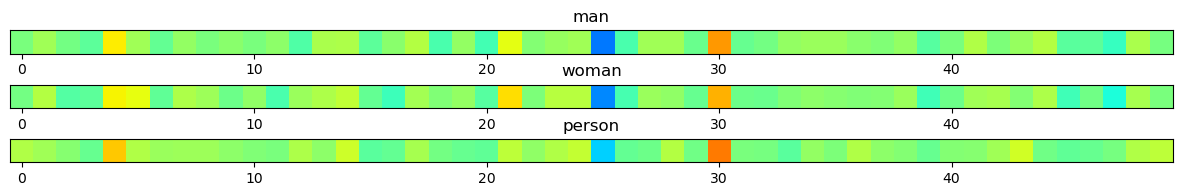

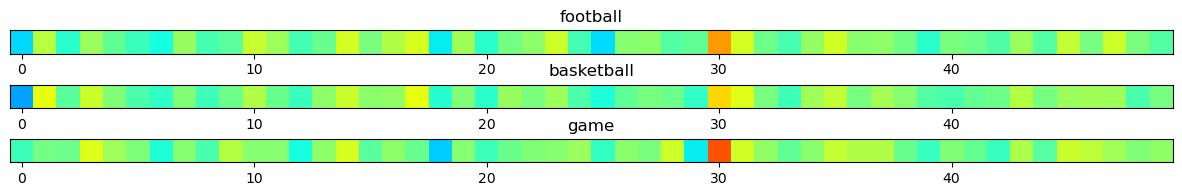

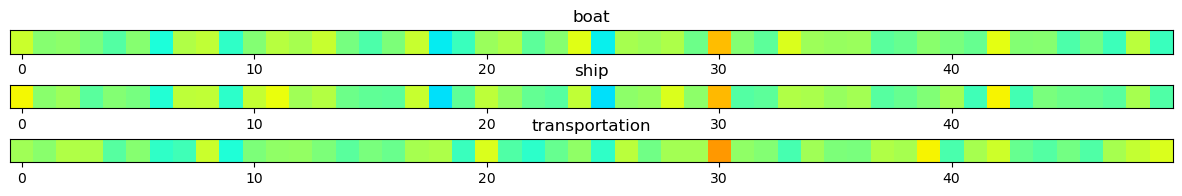

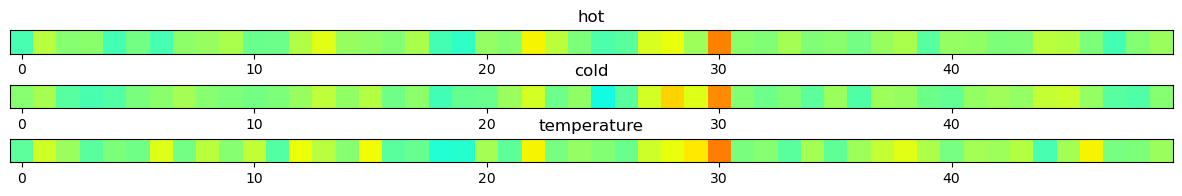

In [5]:

fig = viz_vectors(word_to_vec_map, vec_max, vec_min, 'man', 'woman', 'person')
plt.show()

fig = viz_vectors(word_to_vec_map, vec_max, vec_min, 'football', 'basketball', 'game')
plt.show()

fig = viz_vectors(word_to_vec_map, vec_max, vec_min, 'boat', 'ship', 'transportation')
plt.show()

fig = viz_vectors(word_to_vec_map, vec_max, vec_min, 'hot', 'cold', 'temperature')
plt.show()


## 1.3 Viewing Word Clusters in the Vector Space

Use t-SNE to visualize 50D vector in 2D space


In [6]:
def tsne_plot(model):
    """
    Creates and TSNE model and plots it
    """
    
    labels = []
    tokens = []

    for word in model:  #.wv.vocab
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=2, n_components=2, init='pca', n_iter=2500, random_state=23)

    new_values = tsne_model.fit_transform(np.asarray(tokens))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


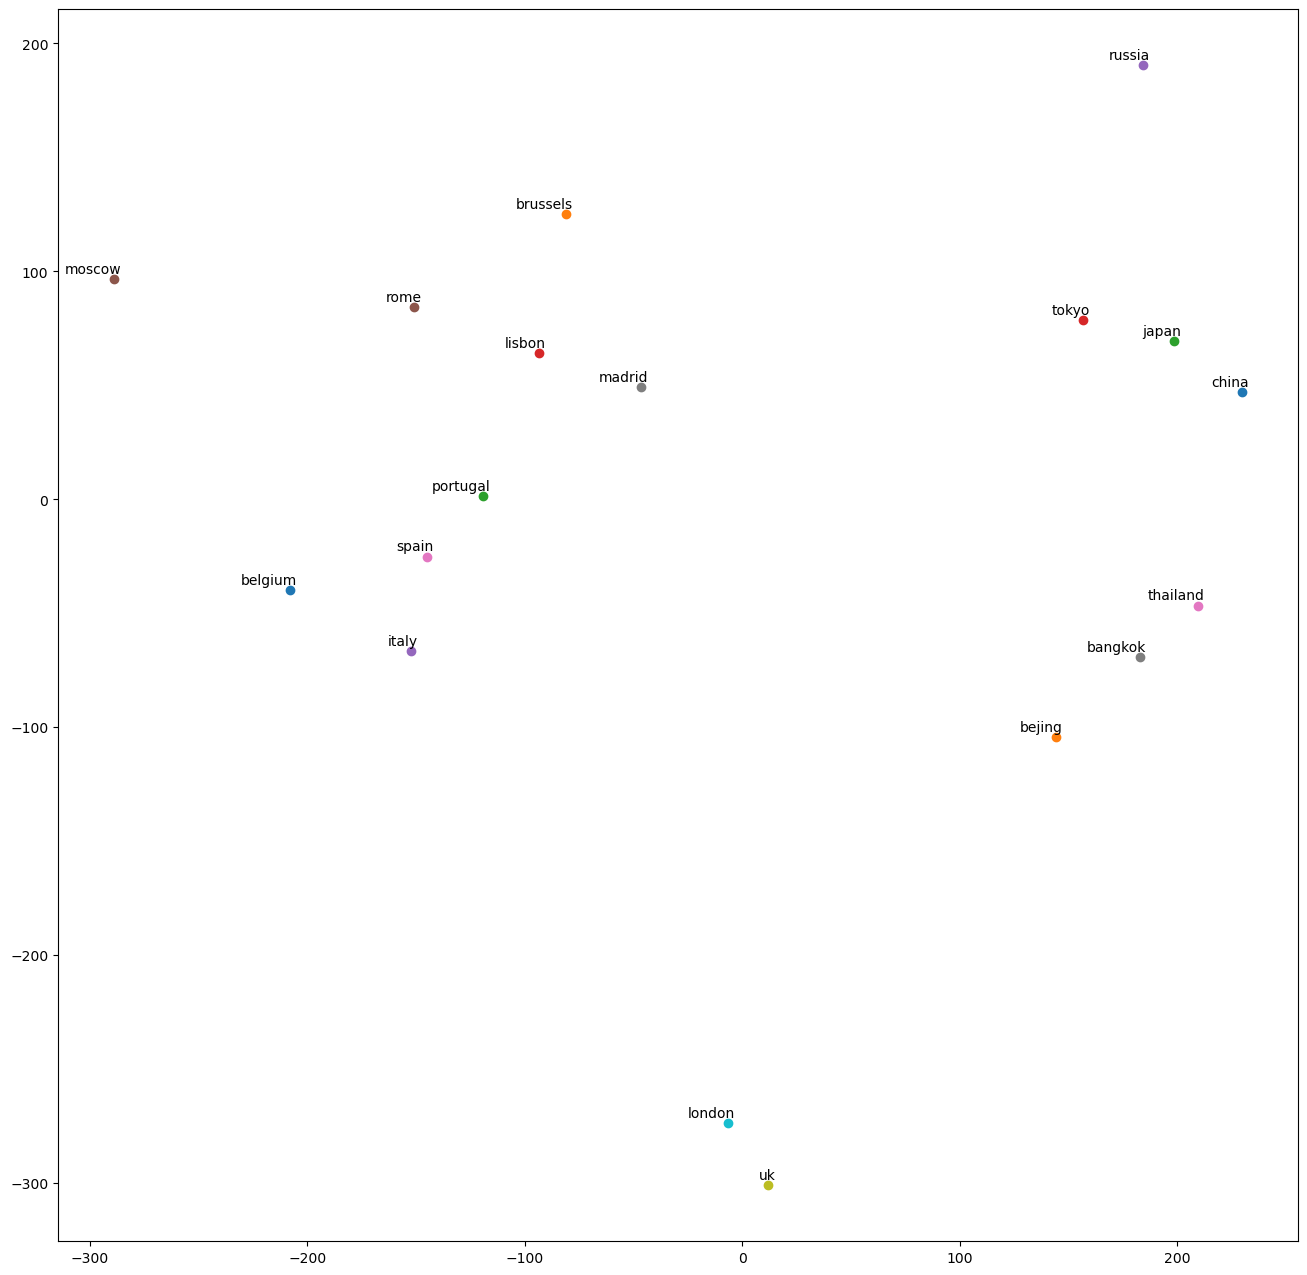

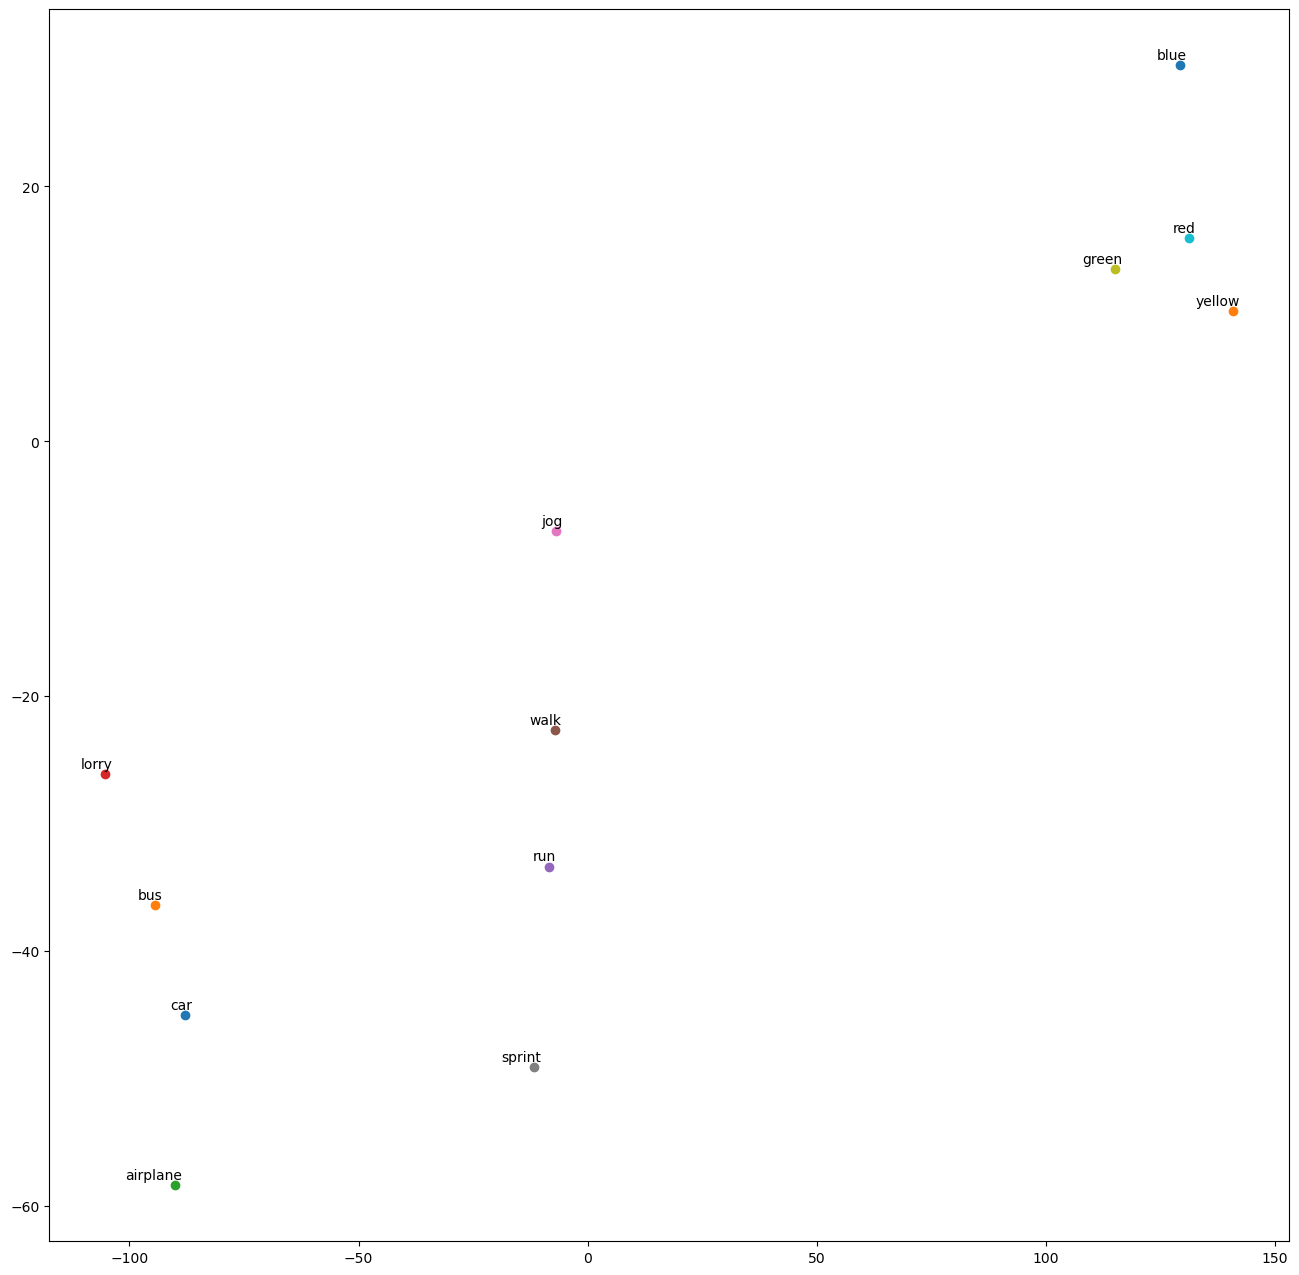

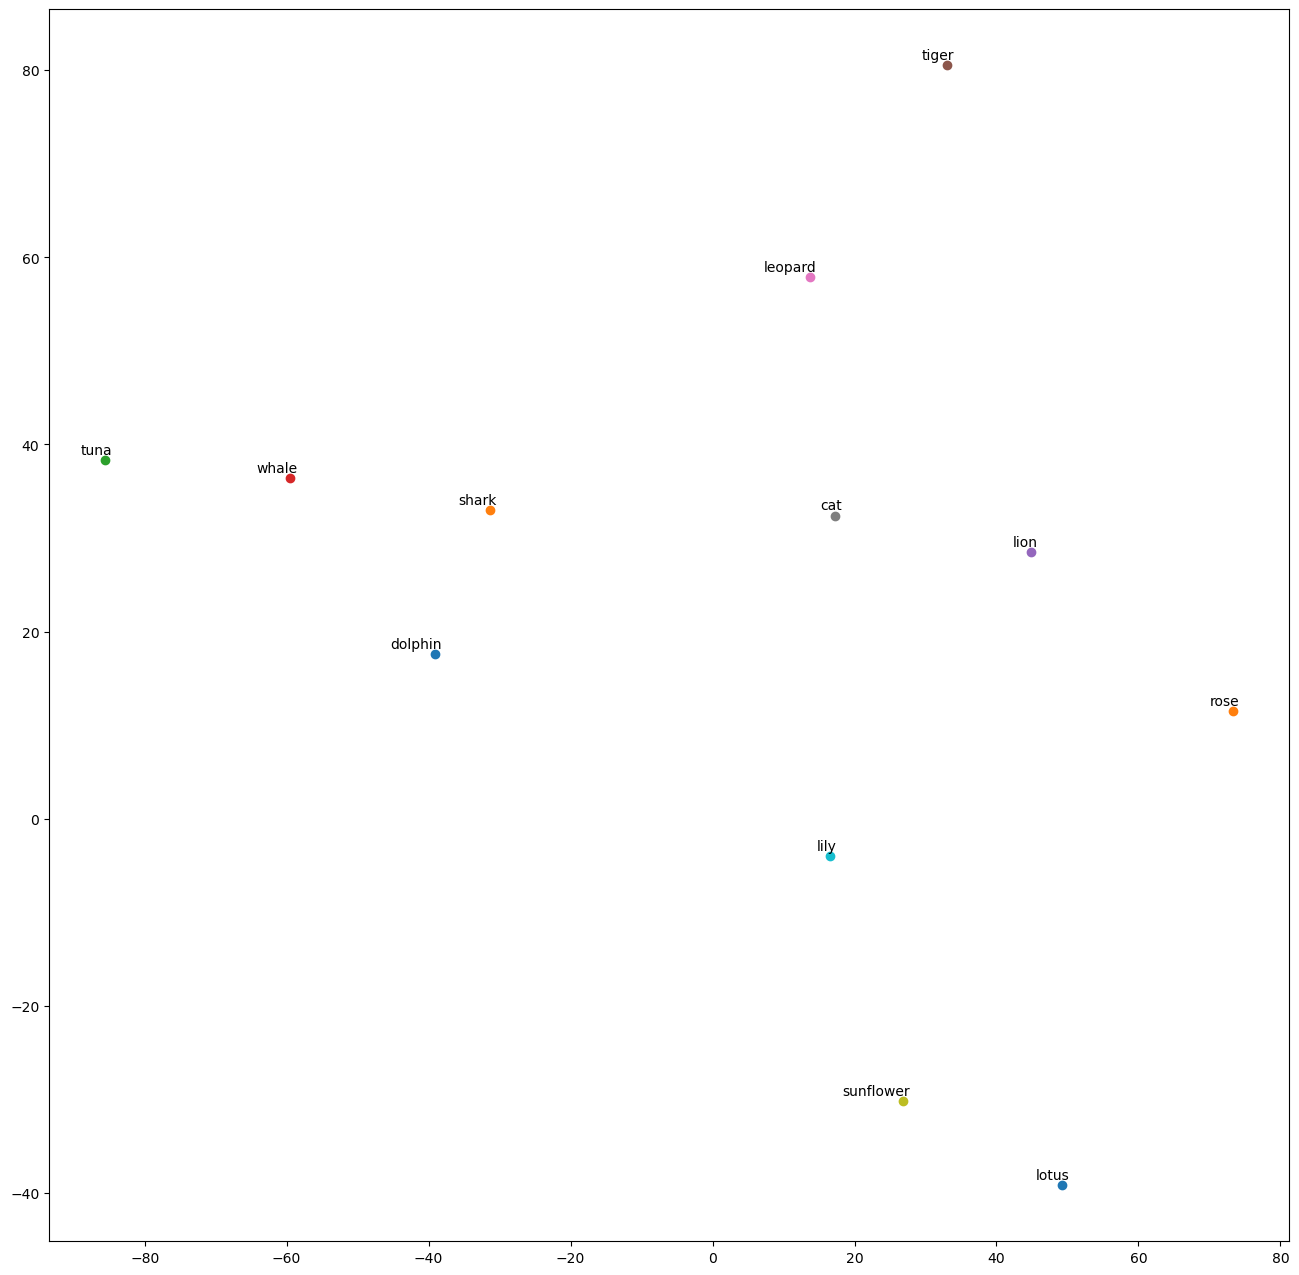

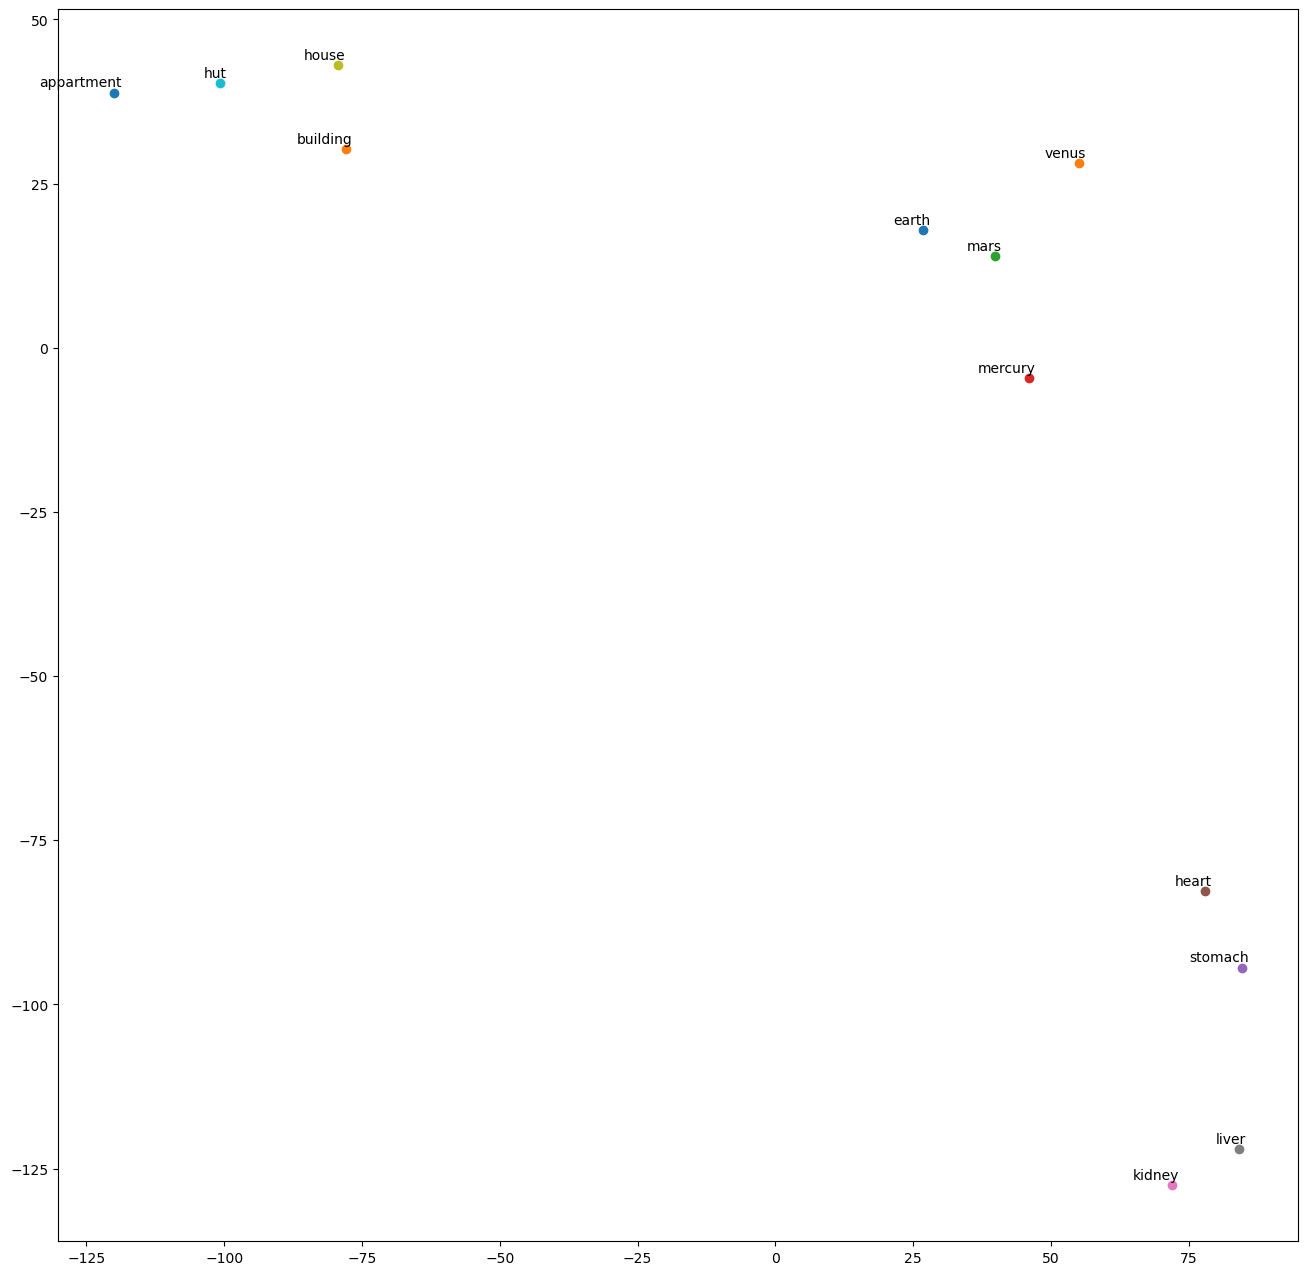

In [7]:
word_list = ('china','bejing', 'japan', 'tokyo', 'italy', 'rome', 'spain', 'madrid', 'uk', 'london'
             ,'belgium', 'brussels', 'portugal', 'lisbon', 'russia','moscow', 'thailand','bangkok')

new_dict = {k:word_to_vec_map[k] for k in word_list if k in word_to_vec_map}

tsne_plot(new_dict)

word_list =('car' ,'bus','airplane', 'lorry','run','walk','jog','sprint', 'green', 'red' ,'blue', 'yellow')

new_dict = {k:word_to_vec_map[k] for k in word_list if k in word_to_vec_map}

tsne_plot(new_dict)

word_list =('dolphin' ,'shark', 'tuna', 'whale',
            'lion', 'tiger', 'leopard', 'cat',
            'sunflower', 'lily', 'lotus', 'rose'
            )

new_dict = {k:word_to_vec_map[k] for k in word_list if k in word_to_vec_map}

tsne_plot(new_dict)


word_list =('earth' ,'venus', 'mars', 'mercury',
            'stomach', 'heart', 'kidney', 'liver',
            'house', 'hut', 'appartment', 'building'
            )

new_dict = {k:word_to_vec_map[k] for k in word_list if k in word_to_vec_map}

tsne_plot(new_dict)

# 2.  Measuring Word Similarity in Vector Space


$$\text{CosineSimilarity(u, v)} = \frac {u . v} {||u||_2 ||v||_2} = cos(\theta) \tag{1}$$

where $u.v$ is the dot product (or inner product) of two vectors, $||u||_2$ is the norm (or length) of the vector $u$, and $\theta$ is the angle between $u$ and $v$. This similarity depends on the angle between $u$ and $v$. If $u$ and $v$ are very similar, their cosine similarity will be close to 1; if they are dissimilar, the cosine similarity will take a smaller value. 

**Note:** The norm of $u$ is defined as $\vert\vert u\vert\vert_2 = \sqrt{\sum_{i=1}^{n} u_i^2}$


In [8]:
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similariy between u and v
        
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """
        
    #Step 1: Compute the dot product between u and v
    dot = u @ v
    #Step 2: Compute the L2 norm of u
    norm_u = np.linalg.norm(u)

    
    #Step 3: Compute the L2 norm of v
    norm_v = np.linalg.norm(v)
    
    # Compute the cosine similarity defined by formula (1)
    cosine_similarity = dot / (norm_u * norm_v)
    
    return cosine_similarity

## 2.1 Testing your Similarity Function


In [9]:
father = word_to_vec_map["father"]
mother = word_to_vec_map["mother"]
ball = word_to_vec_map["ball"]
crocodile = word_to_vec_map["crocodile"]
france = word_to_vec_map["france"]
italy = word_to_vec_map["italy"]
paris = word_to_vec_map["paris"]
rome = word_to_vec_map["rome"]

print("cosine_similarity(father, mother) = ", cosine_similarity(father, mother))
print("cosine_similarity(ball, crocodile) = ",cosine_similarity(ball, crocodile))
print("cosine_similarity(france - paris, rome - italy) = ",cosine_similarity(france - paris, rome - italy))

cosine_similarity(father, mother) =  0.8909038442893615
cosine_similarity(ball, crocodile) =  0.2743924626137943
cosine_similarity(france - paris, rome - italy) =  -0.6751479308174204


# 2.2 - Word Analogy Task

Find a word *d*, such that the associated word vectors $e_a, e_b, e_c, e_d$ are related in the following manner: $e_b - e_a \approx e_d - e_c$. Measure the similarity between $e_b - e_a$ and $e_d - e_c$ using cosine similarity. 

In [10]:

def complete_analogy(word_a, word_b, word_c, word_to_vec_map):
    """
    Performs word analogy: a is to b as c is to ____. 
    
    Arguments:
    word_a -- a word, string
    word_b -- a word, string
    word_c -- a word, string
    word_to_vec_map -- dictionary that maps words to their corresponding vectors. 
    
    Returns:
    best_word --  the word such that v_b - v_a is close to v_best_word - v_c, as measured by cosine similarity
    """
    
    # convert words to lower case
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()
    
    # Get the word embeddings v_a, v_b and v_c
    e_a, e_b, e_c = word_to_vec_map[word_a], word_to_vec_map[word_b], word_to_vec_map[word_c]
    
    words = word_to_vec_map.keys()
    max_cosine_sim = -100              # Initialize max_cosine_sim to a large negative number
    best_word = None                   # Initialize best_word with None, it will help keep track of the word to output

    # loop over the whole word vector set
    for w in words:        
        # to avoid best_word being one of the input words, pass on them.
        if w in [word_a, word_b, word_c] :
            continue
        
        # Compute cosine similarity between the vector (e_b - e_a) and the vector ((w's vector representation) - e_c)
        cosine_sim = cosine_similarity(e_b - e_a, word_to_vec_map[w] - e_c)
        
        # If the cosine_sim is more than the max_cosine_sim seen so far,
            # then: set the new max_cosine_sim to the current cosine_sim and the best_word to the current word
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w
        
    return best_word

In [11]:
triads_to_try = [('italy', 'italian', 'spain'), ('india', 'delhi', 'japan'), ('man', 'woman', 'boy'), ('small', 'smaller', 'large')]

for triad in triads_to_try:
    print ('{} -> {} :: {} -> {}'.format( *triad, complete_analogy(*triad,word_to_vec_map)))

italy -> italian :: spain -> spanish
india -> delhi :: japan -> tokyo
man -> woman :: boy -> girl
small -> smaller :: large -> larger


# 3. Using Counter Factual Testing to Uncover Bias

One way to test for bias in a model is to use counter factual examples. Factual fairness asks the question: <i>How would the prediction change if the sensitive attribute referenced in the example were different?</i>

If the prediction changes with respect to a sensitive attribute, consider this an indicator of a potential problem. In contrast to group-based notions of fairness (e.g., demographic parity, equality of odds), which seek to statistically equalize the model’s behavior for entire sensitive groups (we will see this in the final lab), counter factual fairness requires equal model behavior on individual counter factual pairs.

In this case - use a simple for of counter factual test where: consider perturbations obtained by substituting tokens (words) associated with identity groups. e.g. man with woman, white with Asian, Asian with Black, white with black and so on.


Although it is difficult using this type of limited language structure (word analogy) it is possible to uncover examples of bias.  For example -

- 'white' is to 'boss' what 'black' is to ___
- 'women' is to 'nurse' what 'man' is to ___

In [12]:
triads_to_try = [('white', 'boss', 'black'), 
                 ('women', 'nurse', 'man'),
                 ('boy', 'fast', 'girl'),
                 ('asian', 'math', 'indian'),
                 ('america', 'freedom', 'russia'),
                 ('atheist', 'logical', 'theist'),
                 ('apple', 'good', 'microsoft'),
                 ('sun', 'happy', 'rain'),
                 ('python', 'modern', 'java'),
                 ('british', 'culture', 'irish'),
                 ('dog', 'pet', 'cat'),
                 ('man', 'right', 'woman'),
                 ]

for triad in triads_to_try:
    print ('{} -> {} :: {} -> {}'.format( *triad, complete_analogy(*triad,word_to_vec_map)))

white -> boss :: black -> hitman
women -> nurse :: man -> anesthetist
boy -> fast :: girl -> slow
asian -> math :: indian -> instruction
america -> freedom :: russia -> freedoms
atheist -> logical :: theist -> simplest
apple -> good :: microsoft -> think
sun -> happy :: rain -> frustrating
python -> modern :: java -> cities
british -> culture :: irish -> spirituality
dog -> pet :: cat -> terephthalate
man -> right :: woman -> allowing


# 4. Removing Bias from Word Vector Models

Examine gender biases that can be reflected in a word embedding model, and explore algorithms for reducing the bias.

In [13]:
g = word_to_vec_map['woman'] - word_to_vec_map['man']
print(g)

[-0.087144    0.2182     -0.40986    -0.03922    -0.1032      0.94165
 -0.06042     0.32988     0.46144    -0.35962     0.31102    -0.86824
  0.96006     0.01073     0.24337     0.08193    -1.02722    -0.21122
  0.695044   -0.00222     0.29106     0.5053     -0.099454    0.40445
  0.30181     0.1355     -0.0606     -0.07131    -0.19245    -0.06115
 -0.3204      0.07165    -0.13337    -0.25068714 -0.14293    -0.224957
 -0.149       0.048882    0.12191    -0.27362    -0.165476   -0.20426
  0.54376    -0.271425   -0.10245    -0.32108     0.2516     -0.33455
 -0.04371     0.01258   ]


## 4.1 Word Similarity with Gender, $g$

In [14]:
print ('List of names and their similarities with constructed vector:')

# girls and boys names
name_list = ['john', 'marie', 'sophie', 'ronaldo', 'priya', 'rahul', 'danielle', 'reza', 'katy', 'yasmin']

for w in name_list:
    sim = cosine_similarity(word_to_vec_map[w], g)
    print(w, sim)
    
new_list = ['arvin', 'bani', 'jared', 'konrad', 'simran', 'daisy']

for w in new_list:
    sim = cosine_similarity(word_to_vec_map[w], g)
    print(w, sim)

List of names and their similarities with constructed vector:
john -0.23163356145973724
marie 0.315597935396073
sophie 0.31868789859418784
ronaldo -0.3124479685032943
priya 0.17632041839009402
rahul -0.1691547103923172
danielle 0.24393299216283895
reza -0.07930429672199552
katy 0.2831068659572615
yasmin 0.23313857767928758
arvin -0.10758646648022571
bani -0.06334349977482971
jared -0.20112749113008027
konrad -0.019815649624216284
simran 0.2566437197579292
daisy 0.13097299116037725


Female first names tend to have a positive cosine similarity with the constructed vector $g$, while male first names tend to have a negative cosine similarity.


In [15]:
print('Other words and their similarities:')
word_list = ['lipstick', 'guns', 'science', 'arts', 'literature', 'warrior','doctor', 'tree', 'receptionist', 
             'technology',  'fashion', 'teacher', 'engineer', 'pilot', 'computer', 'singer']

for w in word_list:
    sim = cosine_similarity(word_to_vec_map[w], g)
    print(w, sim)

word_list_2 = ['driver', 'honey', 'chicken', 'model', 'oven',
               'bank', 'road', 'spring', 'laser', 'gamma']

for w in word_list_2:
    sim_2 = cosine_similarity(word_to_vec_map[w], g)
    print (w, sim_2)

Other words and their similarities:
lipstick 0.27691916256382665
guns -0.1888485567898898
science -0.060829065409296994
arts 0.008189312385880328
literature 0.06472504433459927
warrior -0.20920164641125288
doctor 0.11895289410935041
tree -0.07089399175478091
receptionist 0.33077941750593737
technology -0.131937324475543
fashion 0.03563894625772699
teacher 0.17920923431825664
engineer -0.08039280494524072
pilot 0.001076449899191679
computer -0.10330358873850498
singer 0.1850051813649629
driver -0.010681433817247949
honey -0.025182707067508997
chicken -0.0006189024361829258
model 0.034335759603609524
oven 0.011071758806543089
bank -0.1459898347887059
road -0.13831019601576802
spring -0.05738548545642022
laser -0.08858637440365483
gamma -0.15911284478309934


Reduce the bias of these vectors, using an algorithm [2]. Note that some word pairs such as "actor"/"actress" or "grandmother"/"grandfather" should remain gender specific, while other words such as "receptionist" or "technology" should be neutralized, i.e. not be gender-related.

[2] T. Bolukbasi, K.-W. Chang, J. Zou, V. Saligrama, and A. Kalai, “Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings,” Jul. 2016.[Link to Paper](https://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf).

## 4.2 Neutralize Bias in Word Vectors 

`neutralize()` to remove the bias of words such as "receptionist" or "scientist". Given an input embedding $e$, using the following formulas to compute $e^{debiased}$: 

$$e^{bias\_component} = \frac{e \cdot g}{||g||_2^2} * g\tag{2}$$
$$e^{debiased} = e - e^{bias\_component}\tag{3}$$


- Select word vector representation of `word`
- Compute Equation (2)
- Compute Equation (3)



In [16]:
def neutralize(word, g, word_to_vec_map):
    """
    Removes the bias of "word" by projecting it on the space orthogonal to the bias axis. 
    This function ensures that gender neutral words are zero in the gender subspace.
    
    Arguments:
        word -- string indicating the word to debias
        g -- numpy-array of shape (50,), corresponding to the bias axis (such as gender)
        word_to_vec_map -- dictionary mapping words to their corresponding vectors.
    
    Returns:
        e_debiased -- neutralized word vector representation of the input "word"
    """
    
    #Step1: Select word vector representation of "word".
    e = word_to_vec_map[word]
    
    # Compute e_biascomponent using the formula given above.
    e_biascomponent = (np.dot(e, g) / np.square(np.linalg.norm(g))) * g
 
    # Neutralize e by substracting e_biascomponent from it 
    # e_debiased should be equal to its orthogonal projection.
    e_debiased = e - e_biascomponent
    
    return e_debiased

### 4.2.1 Testing your `neutralize` Function

In [17]:
e = "receptionist"
print("cosine similarity between " + e + " and g, before neutralizing: ", cosine_similarity(word_to_vec_map["receptionist"], g))

e_debiased = neutralize("receptionist", g, word_to_vec_map)
print("cosine similarity between " + e + " and g, after neutralizing: ", cosine_similarity(e_debiased, g))

cosine similarity between receptionist and g, before neutralizing:  0.33077941750593737
cosine similarity between receptionist and g, after neutralizing:  1.1682064664487028e-17


## 4.3 Equalization Algorithm to De-bias Word Vectors

Debiasing can also be applied to word pairs such as "actress" and "actor." Equalization is applied to pairs of words that you might want to have differ only through the gender property. As a concrete example, suppose that "actress" is closer to "babysit" than "actor." By applying neutralizing to "babysit" we can reduce the gender-stereotype associated with babysitting. But this still does not guarantee that "actor" and "actress" are equidistant from "babysit." The equalization algorithm takes care of this. 

The key idea behind equalization is to make sure that a particular pair of words are equidistant from the 49-dimensional $g_\perp$. The equalization step also ensures that the two equalized steps are now the same distance from $e_{receptionist}^{debiased}$, or from any other work that has been neutralized. 

The the linear algebra to do this is a bit more complex. (See [2] for more details if you wish). However summarised below are the key steps (equations) to complete the equalization algorithm: 

$$ \mu = \frac{e_{w1} + e_{w2}}{2}\tag{4}$$ 

$$\mu_{B} = \frac{\mu \cdot \text{bias\_axis}}{||\text{bias\_axis}||_2^2} *\text{bias\_axis} \tag{5}$$ 

$$\mu_{\perp} = \mu - \mu_{B} \tag{6}$$

$$ e_{w1B} = \frac{e_{w1} \cdot \text{bias\_axis}}{||\text{bias\_axis}||_2^2} *\text{bias\_axis} \tag{7}$$ 
$$ e_{w2B} = \frac{e_{w2} \cdot \text{bias\_axis}}{||\text{bias\_axis}||_2^2} *\text{bias\_axis} \tag{8}$$


$$e_{w1B}^{corrected} = \sqrt{ |{1 - ||\mu_{\perp} ||^2_2} |} * \frac{e_{\text{w1B}} - \mu_B} {||(e_{w1} - \mu_{\perp}) - \mu_B)||_2} \tag{9}$$


$$e_{w2B}^{corrected} = \sqrt{ |{1 - ||\mu_{\perp} ||^2_2} |} * \frac{e_{\text{w2B}} - \mu_B} {||(e_{w2} - \mu_{\perp}) - \mu_B)||_2} \tag{10}$$

$$e_1 = e_{w1B}^{corrected} + \mu_{\perp} \tag{11}$$
$$e_2 = e_{w2B}^{corrected} + \mu_{\perp} \tag{12}$$

In [18]:
def equalize(pair, bias_axis, word_to_vec_map):
    """
    Debias gender specific words by following an equalize method
    
    Arguments:
    pair -- pair of strings of gender specific words to debias, e.g. ("actress", "actor") 
    bias_axis -- numpy-array of shape (50,), vector corresponding to the bias axis, e.g. gender
    word_to_vec_map -- dictionary mapping words to their corresponding vectors
    
    Returns
    e_1 -- word vector corresponding to the first word
    e_2 -- word vector corresponding to the second word
    """
    
    # Step 1: Select word vector representation of "word"
    e_w1 = word_to_vec_map[pair[0]]
    e_w2 = word_to_vec_map[pair[1]]
    
    # Step 2: Compute the mean of e_w1 and e_w2
    mu = (e_w1 + e_w2) / 2

    # Step 3: Compute the projections of mu over the bias axis and the orthogonal axis
    mu_B = (np.dot(mu, bias_axis) / np.square(np.linalg.norm(bias_axis))) * bias_axis
    mu_orth = mu - mu_B

    # Step 4: Use equations (7) and (8) to compute e_w1B and e_w2B
    e_w1B = (np.dot(e_w1, bias_axis) / np.square(np.linalg.norm(bias_axis))) * bias_axis
    e_w2B = (np.dot(e_w2, bias_axis) / np.square(np.linalg.norm(bias_axis))) * bias_axis
    
    # Step 5: Adjust the Bias part of e_w1B and e_w2B using the formulas (9) and (10)
    corrected_e_w1B = np.sqrt(np.abs(1 - np.square(np.linalg.norm(mu_orth)))) * ((e_w1B - mu_B) / np.linalg.norm((e_w1 - mu_orth) - mu_B))
    corrected_e_w2B = np.sqrt(np.abs(1 - np.square(np.linalg.norm(mu_orth)))) * ((e_w2B - mu_B) / np.linalg.norm((e_w2 - mu_orth) - mu_B))
    
    # Step 6: Debias by equalizing e1 and e2 to the sum of their corrected projections
    e1 = corrected_e_w1B + mu_orth
    e2 = corrected_e_w2B + mu_orth

    return e1, e2

### 4.3.1 Testing your `equalize` Function

In [19]:
print("cosine similarities before equalizing:")
print("cosine_similarity(word_to_vec_map[\"man\"], gender) = ", cosine_similarity(word_to_vec_map["man"], g))
print("cosine_similarity(word_to_vec_map[\"woman\"], gender) = ", cosine_similarity(word_to_vec_map["woman"], g))
print()
e1, e2 = equalize(("man", "woman"), g, word_to_vec_map)
print("cosine similarities after equalizing:")
print("cosine_similarity(e1, gender) = ", cosine_similarity(e1, g))
print("cosine_similarity(e2, gender) = ", cosine_similarity(e2, g))

cosine similarities before equalizing:
cosine_similarity(word_to_vec_map["man"], gender) =  -0.1171109576533683
cosine_similarity(word_to_vec_map["woman"], gender) =  0.3566661884627037

cosine similarities after equalizing:
cosine_similarity(e1, gender) =  -0.7004364289309387
cosine_similarity(e2, gender) =  0.7004364289309386


# 5. Improving Gender Bias and Fairness

These debiasing algorithms are very helpful for reducing bias, but are not perfect and do not eliminate all traces of bias. For example, one weakness of this implementation was that the bias direction $g$ was defined using only the pair of words _woman_ and _man_. As discussed earlier, if $g$ were defined by computing $g_1 = e_{woman} - e_{man}$; $g_2 = e_{mother} - e_{father}$; $g_3 = e_{girl} - e_{boy}$; and so on and averaging over them, to obtain a better estimate of the "gender" direction in the 50 dimensional word embedding space. 
               

In [26]:
#Step 1: create improved gender vector from averaging several gender pairs

word_list = [['man', 'woman'],
             ['king', 'queen'],
             ['husband', 'wife'],
             ['brother', 'sister'],
             ['uncle', 'aunt'],
             ['father', 'mother'],
             ['son', 'daughter'],
             ['lord', 'lady'],
             ['he', 'she'],
             ['mr', 'mrs'],
             ['him', 'her'],
             ['his', 'her'],
             ['dog', 'bitch'],
             ['stallion', 'mare'],
             ['duke', 'dutchess'],
             ['emperor', 'empress'],
             ['fiance', 'fiancee']
            ]

bias = np.sum(np.asarray([word_to_vec_map[i] - word_to_vec_map[j] for i, j in word_list]), axis=0)/len(word_list)
print(f"New bias vector shape: {bias.shape}")

# Sanity check:

print("\n\nSanity check\n\n")

e1, e2 = equalize(("man", "woman"), bias, word_to_vec_map)
print("cosine similarities after equalizing:")
print("cosine_similarity(e1, gender) = ", cosine_similarity(e1, bias))
print("cosine_similarity(e2, gender) = ", cosine_similarity(e2, bias))

#Step 2: debias word embeddings

print("\n\nDebias word embeddings...", end=" ")

for i, j in word_list:
    # equalize pairs
    e1, e2 = equalize((i, j), bias, word_to_vec_map)
    # update word embeddings with debiased word vect
    word_to_vec_map[i], word_to_vec_map[j] = e1, e2

flatten_list = np.asarray(word_list).ravel()

for w in words:
    if w not in flatten_list:
        # neutralize words
        word_to_vec_map[w] = neutralize(w, bias, word_to_vec_map)

print("Completed")
#Step 3: re-run word anlogies (counter factuals).
print("\n\n Word analogies (counter factuals) after debiasing...")
triads_to_try = [('white', 'boss', 'black'), 
                 ('women', 'nurse', 'man'),
                 ('boy', 'fast', 'girl'),
                 ('asian', 'math', 'indian'),
                 ('america', 'freedom', 'russia'),
                 ('atheist', 'logical', 'theist'),
                 ('apple', 'good', 'microsoft'),
                 ('sun', 'happy', 'rain'),
                 ('python', 'modern', 'java'),
                 ('british', 'culture', 'irish'),
                 ('dog', 'pet', 'cat'),
                 ('man', 'right', 'woman'),
                 ]

for triad in triads_to_try:
    print ('{} -> {} :: {} -> {}'.format( *triad, complete_analogy(*triad,word_to_vec_map)))


# Step 4: re-run word-gender simlarities

print ('\n\nList of names and their similarities with constructed vector:')

# girls and boys names
name_list = ['john', 'marie', 'sophie', 'ronaldo', 'priya', 'rahul', 'danielle', 'reza', 'katy', 'yasmin']

for w in name_list:
    sim = cosine_similarity(word_to_vec_map[w], bias)
    print(w, sim)
    
new_list = ['arvin', 'bani', 'jared', 'konrad', 'simran', 'daisy']

for w in new_list:
    sim = cosine_similarity(word_to_vec_map[w], bias)
    print(w, sim)

New bias vector shape: (50,)


Sanity check


cosine similarities after equalizing:
cosine_similarity(e1, gender) =  0.7005492466633614
cosine_similarity(e2, gender) =  -0.7005492466633615


Debias word embeddings... Completed


 Word analogies (counter factuals) after debiasing...
white -> boss :: black -> hitman
women -> nurse :: man -> anesthetist
boy -> fast :: girl -> slow
asian -> math :: indian -> instruction
america -> freedom :: russia -> freedoms
atheist -> logical :: theist -> simplest
apple -> good :: microsoft -> think
sun -> happy :: rain -> frustrating
python -> modern :: java -> cities
british -> culture :: irish -> spirituality
dog -> pet :: cat -> mother
man -> right :: woman -> her


List of names and their similarities with constructed vector:
john -1.3488188808887396e-16
marie 1.1827656866028122e-16
sophie 2.7899249099621667e-18
ronaldo -1.0008045917614651e-16
priya 3.382870280575015e-17
rahul -2.6055129043381186e-17
danielle 1.2076724995726673e-16
reza -2.92574758

In [27]:
print('Other words and their similarities:')
word_list = ['lipstick', 'guns', 'science', 'arts', 'literature', 'warrior','doctor', 'tree', 'receptionist', 
             'technology',  'fashion', 'teacher', 'engineer', 'pilot', 'computer', 'singer']

for w in word_list:
    sim = cosine_similarity(word_to_vec_map[w], bias)
    print(w, sim)

word_list_2 = ['driver', 'honey', 'chicken', 'model', 'oven',
               'bank', 'road', 'spring', 'laser', 'gamma']

for w in word_list_2:
    sim_2 = cosine_similarity(word_to_vec_map[w], bias)
    print (w, sim_2)

Other words and their similarities:
lipstick 7.23367888145512e-17
guns -5.257639293442921e-17
science -3.358548882802402e-17
arts -8.412512851048449e-18
literature -6.664890699325137e-17
warrior 0.0
doctor -9.727245512356702e-18
tree 1.8126535002441265e-17
receptionist 9.155903619799303e-17
technology -5.0271773840827e-17
fashion 9.848093445903015e-18
teacher -2.788552743743604e-17
engineer -7.90551763769815e-17
pilot 0.0
computer -6.49929789196524e-17
singer 0.0
driver 1.6936113175392035e-17
honey 2.493837386914544e-17
chicken 2.5180112303189827e-17
model -1.96927520810417e-17
oven -7.263843274451214e-18
bank -2.7902865788863324e-17
road -4.7394139451191334e-17
spring -6.13653111360658e-17
laser 0.0
gamma -3.441833319114035e-17


<h1> 6. Critical Analysis, Reflection & Discussion</h1>

- What observations have you made when using for counter factuals for bias/fairness detection, specifically
    - its ability to detect potential bias
    > It cannot discern potential bias on its own. An external agent with the ability to contextualize and understand complex relations is required to detect bias.
    - its ability to verify removal of bias
    > Since it cannot detect bias in the first place, similarly it can't verify its removal. Again an external agent is required to make such a distinction based on new values output by the model for same words.
- What considerations might you make to the design of the improved Gender bias Vector to maximise fairness in the debiasing algorithm.
     - How do you think we should design the list of word pairs that generate $g_{av}$?
     > Include pronouns (his-her), relationships(brother-sister), status(king-queen), pairs gendered words even for animals (dog-bitch), etc. Such a list is in no way meant to be unbiased as there will always be some bias created by the creator itself, therefore, it would be better to have such a list compiled with open standards to make modification easy and agreed upon by a cohort.
- What evidence have you found that this approach to de-biasing word vectors is effective?
> Algorithm was successfully able to remove gendered bias from words thus the cosine similarity results with new gender vector is close to 0 or of the order of 10 to -17.
- What are the limitations to this approach to de-biasing and why?
> Potential bias introduced by the programmer or the cohort maintaining the list. It may not be able to preserver context with other related words.
- Can you think of approaches and actions that can help mitigate any limitations
    > An resource intensive as it may be, exhaustive list of gendered pair words to obtain the best possible gender bias vector would be the ideal scenario.
- Think about and suggest an approach on how you might de-bias a non-linear model space.
> One approach would be to transform the non-linear space to a linear one to apply the same de-biasing algorithm and then transform the new linear space back to original non-linear space. One advantage is that we must only figure out the transformation operation required here.